In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *

from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm
import tensorflow as tf
from keras.applications.vgg16 import VGG16

In [ ]:
path = '/content/drive/MyDrive/research/segmentation/test_fcn'
os.mkdir(path)


path = '/content/drive/MyDrive/research/segmentation/train_fcn'
os.mkdir(path)


path = '/content/drive/MyDrive/research/segmentation/train_fcn/augmentation'
os.mkdir(path)


path = '/content/drive/MyDrive/research/segmentation/train_fcn/mask'
os.mkdir(path)


path = '/content/drive/MyDrive/research/segmentation/train_fcn/dilate'
os.mkdir(path)


path = '/content/drive/MyDrive/research/segmentation/train_fcn/image'
os.mkdir(path)

FileExistsError: ignored

In [ ]:
input_dir = os.path.join('/content','drive','MyDrive','research')
segmentation_dir = os.path.join(input_dir,'segmentation')
segmentation_test_dir = os.path.join(segmentation_dir,'test_fcn')
segmentation_train_dir = os.path.join(segmentation_dir,'train_fcn')
segmentation_aug_dir = os.path.join(segmentation_train_dir,'augmentation')
segmentation_image_dir = os.path.join(segmentation_train_dir,'image')
segmentation_mask_dir= os.path.join(segmentation_train_dir,"mask")
segmentation_dilate_dir = os.path.join(segmentation_train_dir,"dilate")
train_dir = os.path.join(input_dir,"Thyroid_files")
image_dir = os.path.join(train_dir,"ultrasound_png")
mask_dir = os.path.join(train_dir,"mask","mask1")

DILATE_KERNEL = np.ones((15, 15), np.uint8)
BATCH_SIZE=2
EPOCHS=60

In [ ]:
  def add_colored_dilate(image,mask_image,dilate_image):
     mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)
     dilate_image_gray = cv2.cvtColor(dilate_image,cv2.COLOR_BGR2GRAY)
     mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)
     dilate = cv2.bitwise_and(dilate_image,dilate_image,mask=dilate_image_gray)
     mask_coord = np.where(mask!=[0,0,0])
     dilate_coord = np.where(dilate!=[0,0,0])

     mask[mask_coord[0],mask_coord[1],:] = [255,0,0]
     dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

     ret = cv2.addWeighted(image,0.7,dilate,0.3,0)
     ret = cv2.addWeighted(ret,0.7,mask,0.3,0)

     return ret
  def add_colored_mask(image,mask_image):
    mask_image_grey = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_grey)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(image,0.7,mask,0.3,0)

    return ret
  def diff_mask(ref_image,mask_image):
    mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(ref_image,0.7,mask,0.3,0)
    return ret


In [ ]:
mask_dir_1 = glob(os.path.join(mask_dir,'*.png'))
test = mask_dir_1[0:62]
train = mask_dir_1[62:]

for mask_file in tqdm(mask_dir_1):
  base_file = os.path.basename(mask_file).replace("_mask","")
  image_file = os.path.join(image_dir,base_file)

  image = cv2.imread(image_file)
  mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)


  mask_dilate = cv2.dilate(mask,DILATE_KERNEL,iterations=1)

  if (mask_file in train):
        cv2.imwrite(os.path.join(segmentation_image_dir , base_file), \
                    image)
        cv2.imwrite(os.path.join(segmentation_mask_dir, base_file), \
                    mask)
        cv2.imwrite(os.path.join(segmentation_dilate_dir, base_file), \
                    mask_dilate)

  else:
    filename,fileext = os.path.splitext(base_file)
    cv2.imwrite(os.path.join(segmentation_test_dir, base_file), \
                    image)
    cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 306/306 [00:09<00:00, 31.72it/s]


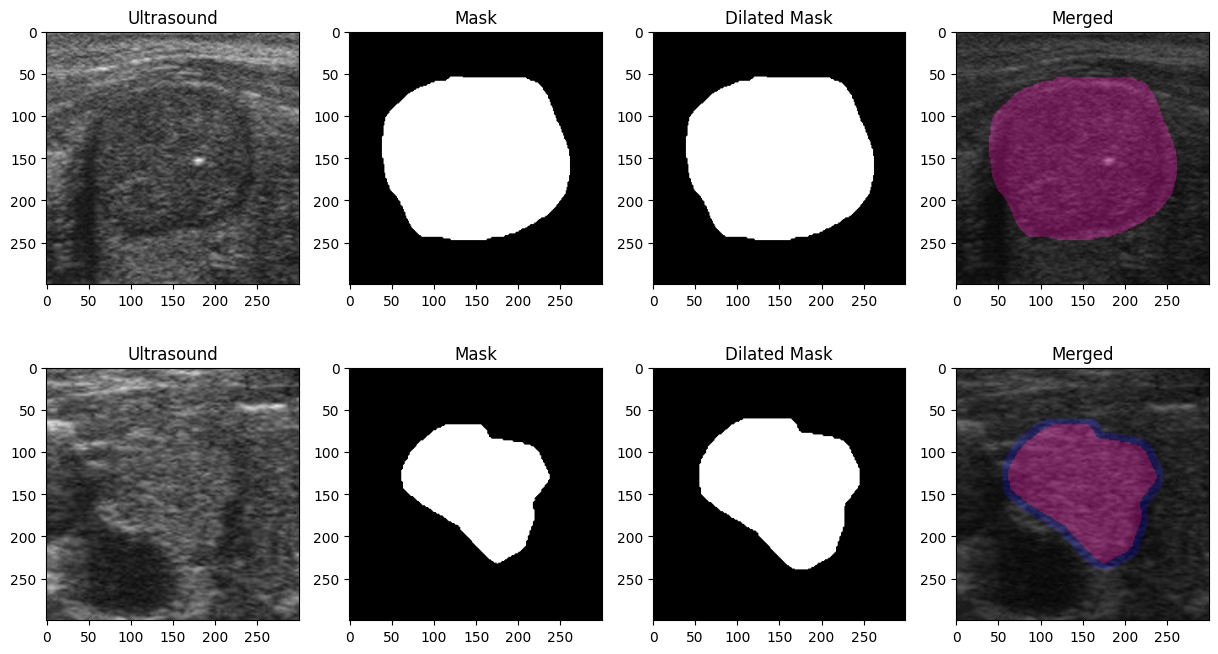

In [ ]:
base_file = os.path.basename(train[0].replace("_mask",""))
image_file = os.path.join(segmentation_image_dir,base_file)
mask_image_file = os.path.join(segmentation_dilate_dir,base_file)
dilate_image_file = os.path.join(segmentation_dilate_dir,base_file)
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
fig,axs = plt.subplots(2,4,figsize=(15,8))

axs[0, 0].set_title("Ultrasound")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilated Mask")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(test[0].replace("_mask",""))
image_file = os.path.join(segmentation_test_dir,base_file)
filename,fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(segmentation_test_dir, base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext))
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("Ultrasound")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilated Mask")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
train_files = glob(os.path.join(segmentation_image_dir, "*.png"))
test_files = glob(os.path.join(segmentation_test_dir, "*.png"))
mask_files = glob(os.path.join(segmentation_mask_dir, "*.png"))
dilate_files = glob(os.path.join(segmentation_dilate_dir, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(244, 186, 244, 244)

In [ ]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def mean_iou(y_true, y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)

def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())

def precision(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
num_classes = 1

def FCN_8(input_size = (256,256,1)):

    input_graph = Input(input_size)

    graph = ZeroPadding2D(padding=100)(input_graph)

    #block_1
    graph = Conv2D(64, 3, padding='same', activation='relu', use_bias=True, name='block1_conv1')(graph)
    graph = Conv2D(64, 3, padding='same', activation='relu', use_bias=True, name='block1_conv2')(graph)
    graph = MaxPooling2D(pool_size=(2, 2), padding='valid', name='block1_pool')(graph)

    #block_2
    graph = Conv2D(128, 3, padding='same', activation='relu', use_bias=True, name='block2_conv1')(graph)
    graph = Conv2D(128, 3, padding='same', activation='relu', use_bias=True, name='block2_conv2')(graph)
    graph = MaxPooling2D(pool_size=(2, 2), padding='valid', name='block2_pool')(graph)

    #block_3
    graph = Conv2D(256, 3, padding='same', activation='relu', use_bias=True, name='block3_conv1')(graph)
    graph = Conv2D(256, 3, padding='same', activation='relu', use_bias=True, name='block3_conv2')(graph)
    graph = Conv2D(256, 3, padding='same', activation='relu', use_bias=True, name='block3_conv3')(graph)
    graph = MaxPooling2D(pool_size=(2, 2), padding='valid', name='block3_pool')(graph)
#    graph = Dropout(0.4)(graph)

    pool_3 = graph

#    print(pool_3.shape)

    #block_4
    graph = Conv2D(512, 3, padding='same', activation='relu', use_bias=True, name='block4_conv1')(graph)
    graph = Conv2D(512, 3, padding='same', activation='relu', use_bias=True, name='block4_conv2')(graph)
    graph = Conv2D(512, 3, padding='same', activation='relu', use_bias=True, name='block4_conv3')(graph)
    graph = MaxPooling2D(pool_size=(2, 2), padding='valid', name='block4_pool')(graph)
#    graph = Dropout(0.4)(graph)

    pool_4 = graph

#    print(pool_4.shape)

    #block_5
    graph = Conv2D(512, 3, padding='same', activation='relu', use_bias=True, name='block5_conv1')(graph)
    graph = Conv2D(512, 3, padding='same', activation='relu', use_bias=True, name='block5_conv2')(graph)
    graph = Conv2D(512, 3, padding='same', activation='relu', use_bias=True, name='block5_conv3')(graph)
    graph = MaxPooling2D(pool_size=(2, 2), padding='valid', name='block5_pool')(graph)

    #fc_6
    graph = Conv2D(4096, 7, padding='valid', activation='relu', use_bias=True, name='fc_1')(graph)
    graph = Dropout(0.5)(graph)

    #fc_7
    graph = Conv2D(4096, 1, padding='valid', activation='relu', use_bias=True, name='fc_2')(graph)
    graph = Dropout(0.5)(graph)

    encoder_graph = Conv2D(num_classes, 1, padding='valid', activation='relu', use_bias=True, name='encoder_graph')(graph)

    score_2 = Conv2DTranspose(num_classes, 4, strides=(2, 2), padding='same')( encoder_graph)
    score_pool_4 = Conv2D(num_classes, 1, padding='same', use_bias=True)(pool_4)
    score_pool_4 = Cropping2D(cropping=6)(score_pool_4)
    score_16x_upsampled = Add()([score_2, score_pool_4])

    # Unpool to image shape
    upsample = Conv2DTranspose(num_classes, 32, strides=(16, 16), padding='same')(score_16x_upsampled)
    output_graph = Activation('sigmoid')(upsample)

    return Model(inputs=[input_graph], outputs=[output_graph])

In [ ]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)

def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [ ]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(segmentation_test_dir, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(256, 256)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(256, 256)))

len(test_files), len(validation_data)


(62, 2)

In [ ]:
ACCURACY_THRESHOLD = 0.9

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_binary_accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            segmentation_train_dir,
                            'image',
                            'dilate',
                            train_generator_args,
                            target_size=(256,256),
                            save_to_dir=os.path.abspath(segmentation_aug_dir))

model = FCN_8(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, mean_iou,recall,precision,sensitivity,specificity,'binary_accuracy'
                           ])
model.summary()

model_checkpoint = ModelCheckpoint('fcn8_lung_seg.hdf5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=[model_checkpoint,callbacks],
                              validation_data = validation_data)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 456, 456, 1)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 456, 456, 64  640         ['zero_padding2d_1[0][0]']       
                                )                                                           

122/122 [==============================] - ETA: 0s - loss: -0.4201 - dice_coef: 0.4201 - mean_iou: 0.2858 - recall: 0.5720 - precision: 0.3684 - sensitivity: 0.5720 - specificity: 0.4229 - binary_accuracy: 0.4784
Epoch 1: loss improved from inf to -0.42011, saving model to fcn8_lung_seg.hdf5
122/122 [==============================] - 74s 464ms/step - loss: -0.4201 - dice_coef: 0.4201 - mean_iou: 0.2858 - recall: 0.5720 - precision: 0.3684 - sensitivity: 0.5720 - specificity: 0.4229 - binary_accuracy: 0.4784 - val_loss: -0.3502 - val_dice_coef: 0.3502 - val_mean_iou: 0.2135 - val_recall: 0.5471 - val_precision: 0.2592 - val_sensitivity: 0.5471 - val_specificity: 0.4508 - val_binary_accuracy: 0.4741
Epoch 2/60
122/122 [==============================] - ETA: 0s - loss: -0.4484 - dice_coef: 0.4484 - mean_iou: 0.2913 - recall: 0.5826 - precision: 0.3726 - sensitivity: 0.5826 - specificity: 0.4268 - binary_accuracy: 0.4839
Epoch 2: loss improved from -0.42011 to -0.44844, saving model to fcn

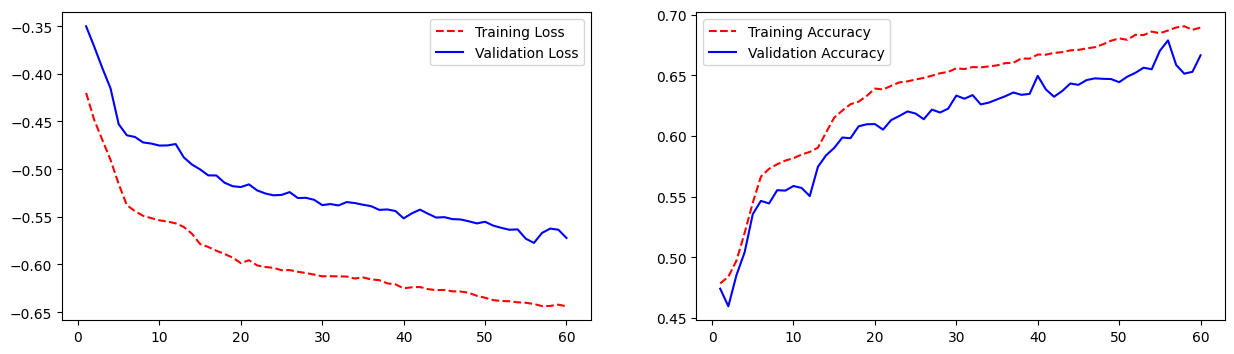

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

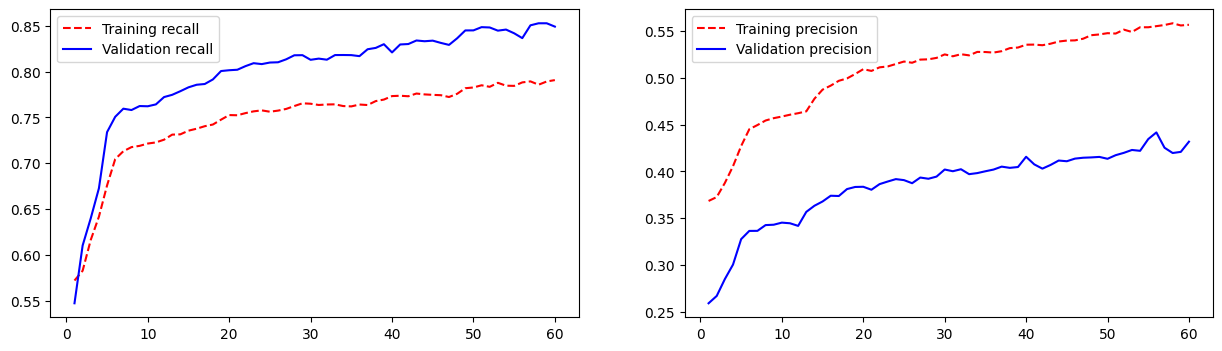

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = history.history['recall']
validation_recall = history.history['val_recall']

training_precision = history.history['precision']
validation_precision = history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])

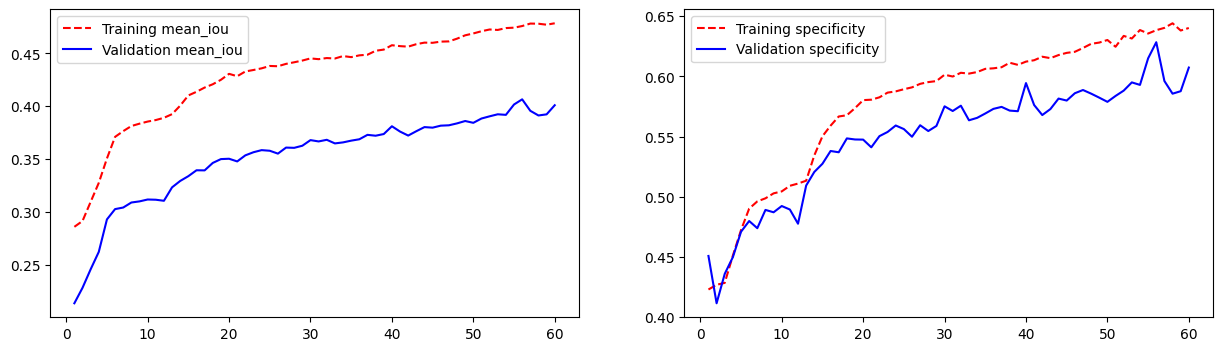

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou = history.history['mean_iou']
validation_mean_iou = history.history['val_mean_iou']

training_specificity = history.history['specificity']
validation_specificity = history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training mean_iou', 'Validation mean_iou'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])

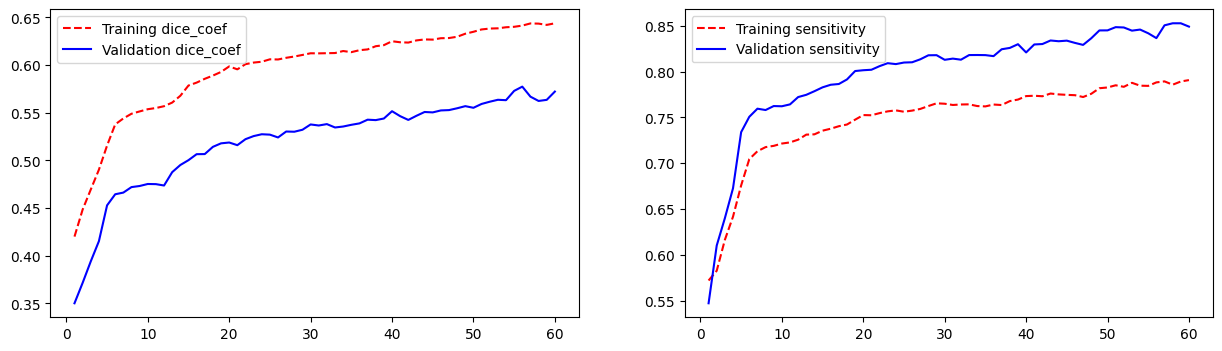

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_dice_coef = history.history['dice_coef']
validation_dice_coef = history.history['val_dice_coef']

training_sensitivity = history.history['sensitivity']
validation_sensitivity = history.history['val_sensitivity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_dice_coef, 'r--')
axs[0].plot(epoch_count, validation_dice_coef, 'b-')
axs[0].legend(['Training dice_coef', 'Validation dice_coef'])

axs[1].plot(epoch_count, training_sensitivity, 'r--')
axs[1].plot(epoch_count, validation_sensitivity, 'b-')
axs[1].legend(['Training sensitivity', 'Validation sensitivity'])

In [ ]:
test_gen = test_generator(test_files, target_size=(256,256))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(segmentation_test_dir, results, test_files)

<ipython-input-45-413e009a05ca>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_gen, len(test_files), verbose=1)


62/62 [==============================] - 6s 84ms/step


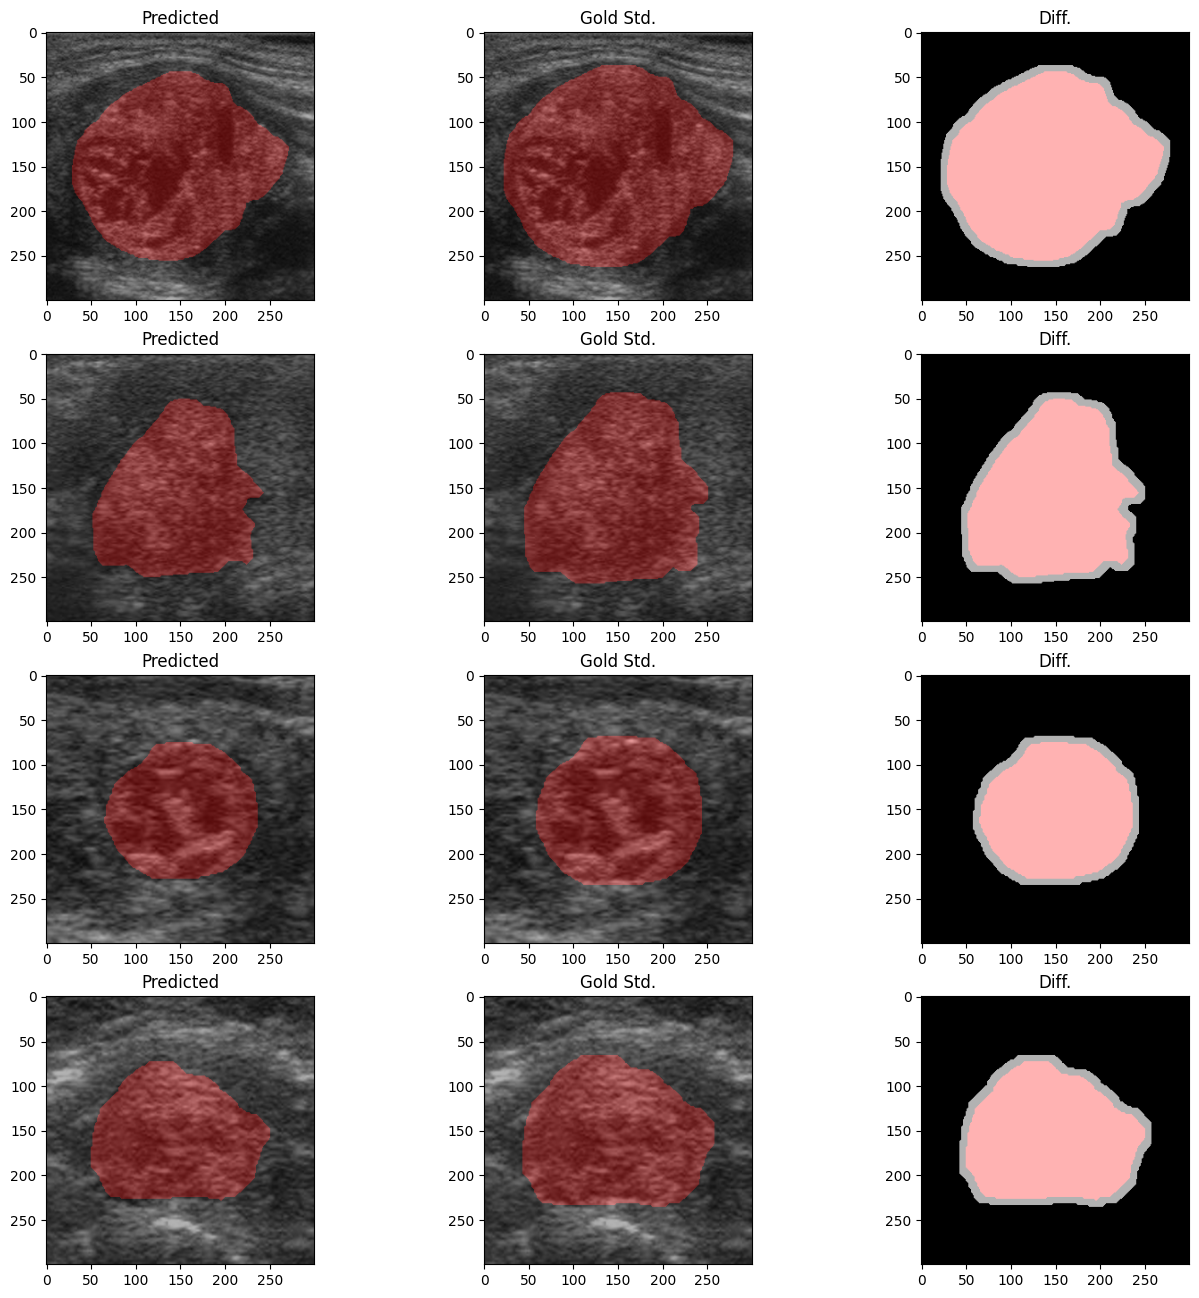

In [ ]:
image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/4.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/4_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/4_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/5.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/5_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/5_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/6.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/6_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/6_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/7.png")
predict_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/7_mask.png")
mask_image = cv2.imread("/content/drive/MyDrive/research/segmentation/test_fcn/7_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))